# Imports 

In [45]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.pipeline import make_pipeline, Pipeline
from lockdowndates.core import LockdownDates
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from scipy.stats import probplot
import seaborn as sns


from catboost import CatBoostRegressor
import datetime
from datetime import timedelta, date

sns.set(style="whitegrid")

In [11]:
X, y = utils.get_train_data()
X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")

In [31]:
num_features = ["temp", "precip", "windspeed", "visibility"]
cat_features = ["counter_id"]
time_features = ["hour", "month", "weekday", "day"]

col_transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(sparse=False), cat_features),
        ("time", FunctionTransformer(utils.encode_cyclical_features), time_features),
    ],
    remainder="passthrough",
)

X, y = utils.get_train_data()

X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")
X_train, y_train, X_test, y_test = utils.train_test_split_temporal(
    X, y, delta_threshold="30 days"
)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
rmse_models = {
    "Linear Regression (Ridge)": [],
    "Linear Regression (Lasso)": [],
    "XGBoost Regressor": [],
    "CatBoost Regressor": [],
}

# Cat Boost

In [33]:
cat = CatBoostRegressor(verbose=0)

pipe = Pipeline(
    [
        ("prepro", FunctionTransformer(utils.prepro)),
        ("col", col_transformer),
        ("model", cat),
    ]
)


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse_models["CatBoost Regressor"] = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error: {rmse_models['CatBoost Regressor']}")

Root Mean Squared Error: 0.43805899877256893


## Linear Reg: Lasso

In [34]:
lasso_reg = Lasso()

pipe = Pipeline(
    [
        ("prepro", FunctionTransformer(utils.prepro)),
        ("col", col_transformer),
        ("model", lasso_reg),
    ]
)


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse_models["Linear Regression (Lasso)"] = np.sqrt(
    mean_squared_error(y_test, predictions)
)
print(f"Root Mean Squared Error: {rmse_models['Linear Regression (Lasso)']}")

Root Mean Squared Error: 1.4912815630969098


## Linear Reg: Ridge

In [35]:
ridge_reg = Ridge(alpha=1.0)

pipe = Pipeline(
    [
        ("prepro", FunctionTransformer(utils.prepro)),
        ("col", col_transformer),
        ("model", ridge_reg),
    ]
)


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse_models["Linear Regression (Ridge)"] = np.sqrt(
    mean_squared_error(y_test, predictions)
)
print(f"Root Mean Squared Error: {rmse_models['Linear Regression (Ridge)']}")

Root Mean Squared Error: 0.8966827622783685


## XGBoost 

In [36]:
xg = xgb.XGBRegressor()

pipe = Pipeline(
    [
        ("prepro", FunctionTransformer(utils.prepro)),
        ("col", col_transformer),
        ("model", xg),
    ]
)


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse_models["XGBoost Regressor"] = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error: {rmse_models['XGBoost Regressor']}")

Root Mean Squared Error: 0.4667399075463249


## Plot Results

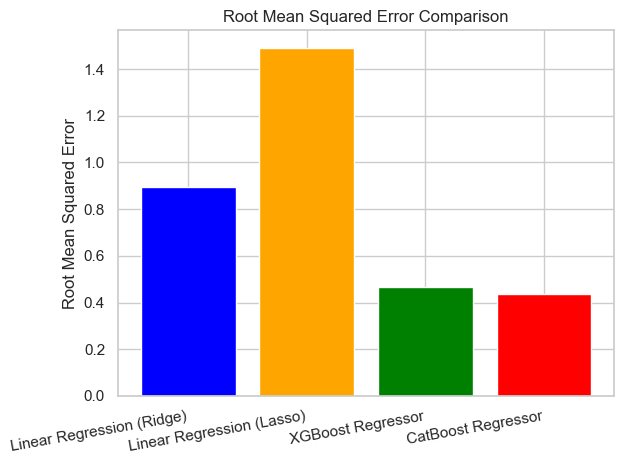

In [50]:
plt.bar(
    rmse_models.keys(), rmse_models.values(), color=["blue", "orange", "green", "red"]
)
plt.title("Root Mean Squared Error Comparison")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.savefig("hist_compare_rmse_models.jpg", format="jpg")

## Residuals

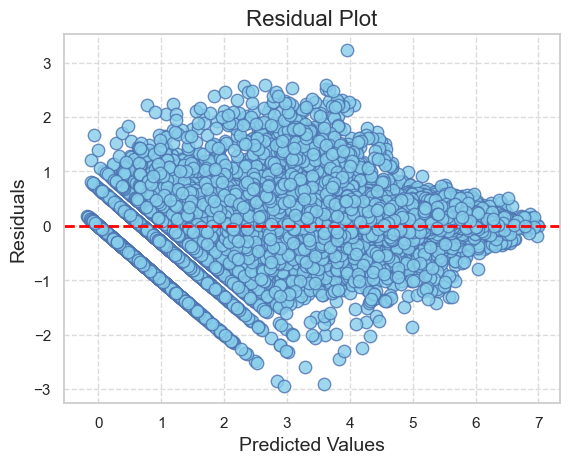

In [51]:
cat = CatBoostRegressor(depth=12, iterations=1000, rsm=0.3, subsample=0.7, verbose=0)

pipe = Pipeline(
    [
        ("prepro", FunctionTransformer(utils.prepro)),
        ("col", col_transformer),
        ("model", cat),
    ]
)

pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

residuals = y_test - predictions

# Scatter plot of residuals against predicted values
plt.scatter(predictions, residuals, alpha=0.8, color="skyblue", edgecolors="b", s=80)

# Add a horizontal line at y=0 for reference
plt.axhline(0, color="red", linestyle="--", linewidth=2)

# Customize the plot
plt.title("Residual Plot", fontsize=16)
plt.xlabel("Predicted Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("residuals_final_catboost.jpg", format="jpg")
plt.show()

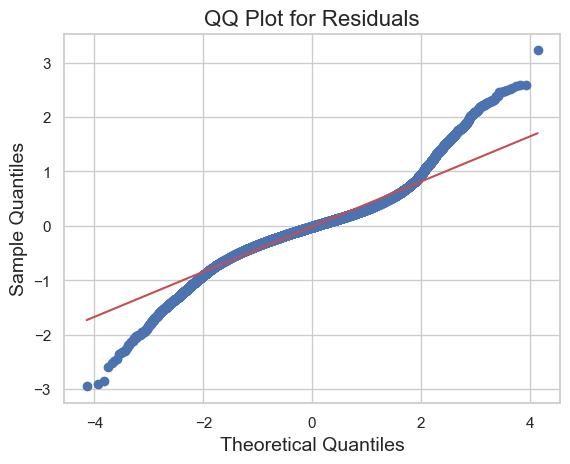

In [48]:
probplot(residuals.flatten(), plot=plt, fit=True)
plt.title("QQ Plot for Residuals", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)
plt.show()